In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely import wkt

import geopandas as gpd
import pandas as pd
from shapely import wkt
import json
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import GOSTnets as gn
import logging
import datetime

import itertools
from multiprocessing import Pool, cpu_count
import multiprocessing

In [10]:
##Logger
logging.root.handlers.clear()
logging.root.handlers

# timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
# log_filename = f"logs/CuscoEdgesWaze1400_{timestamp}.log"

# logging.basicConfig(
#     level=logging.INFO,
#     datefmt='%Y-%m-%d %H:%M:%S',
# )

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logFormatter = logging.Formatter('%(asctime)s :: %(levelname)s :: %(name)s :: %(process)d :: %(message)s')

# fileHandler = logging.FileHandler(log_filename)
# fileHandler.setFormatter(logFormatter)
# logger.addHandler(fileHandler)

streamHandler = logging.StreamHandler()
streamHandler.setFormatter(logFormatter)
logger.addHandler(streamHandler)
##Logger

In [11]:
mapaLimaCallao = pd.read_csv('../SimBig22/rutas/MapaLimaCallao.csv')
mapaLimaCallao['geometry'] = mapaLimaCallao['geometry'].apply(wkt.loads)
mapaLimaCallao = gpd.GeoDataFrame(mapaLimaCallao, crs='epsg:4326')
mapaLimaCallao['distrito2'] = mapaLimaCallao.apply(lambda x: x['distrito'].replace(' ','_'), axis=1)
mapaLimaCallao.head()

,iddpto,departamen,idprov,provincia,iddist,distrito,capital,codccpp,area,fuente,geometry,LimaCallao,distrito2
0,7,CALLAO,701,CALLAO,70105,LA PUNTA,LA PUNTA,1,1,INEI,"POLYGON ((-77.15884 -12.06645, -77.15874 -12.0...",True,LA_PUNTA
1,7,CALLAO,701,CALLAO,70104,LA PERLA,LA PERLA,1,1,INEI,"POLYGON ((-77.10444 -12.07020, -77.10486 -12.0...",True,LA_PERLA
2,7,CALLAO,701,CALLAO,70102,BELLAVISTA,BELLAVISTA,1,1,INEI,"POLYGON ((-77.10086 -12.06307, -77.10317 -12.0...",True,BELLAVISTA
3,7,CALLAO,701,CALLAO,70103,CARMEN DE LA LEGUA REYNOSO,CARMEN DE LA LEGUA REYNOSO,1,1,INEI,"POLYGON ((-77.08317 -12.03925, -77.08263 -12.0...",True,CARMEN_DE_LA_LEGUA_REYNOSO
4,7,CALLAO,701,CALLAO,70101,CALLAO,CALLAO,1,1,INEI,"POLYGON ((-77.11219 -11.97352, -77.11203 -11.9...",True,CALLAO


In [12]:
lima_nodes = pd.read_csv("data/GrafoLima_nodes.csv", index_col=[0])
lima_nodes['geometry'] = lima_nodes['geometry'].apply(wkt.loads)
lima_nodes = gpd.GeoDataFrame(lima_nodes, crs='epsg:4326')

lima_edges = pd.read_csv("data/GrafoLima_edgeswaze.csv", index_col=[0,1,2])
lima_edges['geometry'] = lima_edges['geometry'].apply(wkt.loads)
lima_edges = gpd.GeoDataFrame(lima_edges, crs='epsg:4326')

/home/leibnitz.rojas/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (5,7,13,14,15,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
lima_edges.head()

osmid  oneway lanes  \
u         v           key                                                     
258066779 10985400003 0                              39457621    True     1   
          258066780   0    [1046533254, 338193454, 143630423]    True     2   
258066780 258066781   0                             143630430    True     2   
258066781 258066783   0                             143630430    True     2   
          495302399   0                              40752940    True     1   

                                 highway maxspeed    length  \
u         v           key                                     
258066779 10985400003 0    motorway_link       80   109.492   
          258066780   0         motorway      100   782.922   
258066780 258066781   0            trunk      100  1301.315   
258066781 258066783   0            trunk      100   194.871   
          495302399   0       trunk_link      NaN    85.154   

                                                                    geometry  \
u         v           key                                                      
258066779 10985400003 0    LINESTRING (-76.78468 -12.37136, -76.78466 -12...   
          258066780   0    LINESTRING (-76.78468 -12.37136, -76.78433 -12...   
258066780 258066781   0    LINESTRING (-76.77956 -12.37632, -76.77670 -12...   
258066781 258066783   0    LINESTRING (-76.77105 -12.38455, -76.76977 -12...   
          495302399   0    LINESTRING (-76.77105 -12.38455, -76.77099 -12...   

                             ref                        name bridge  ...  \
u         v           key                                            ...   
258066779 10985400003 0      NaN                         NaN    NaN  ...   
          258066780   0    PE-1S  Carretera Panamericana Sur    yes  ...   
258066780 258066781   0    PE-1S  Carretera Panamericana Sur    NaN  ...   
258066781 258066783   0    PE-1S  Carretera Panamericana Sur    NaN  ...   
          495302399   0      NaN                         NaN    NaN  ...   

                          access tunnel width  service  \
u         v           key                                
258066779 10985400003 0      NaN    NaN   NaN      NaN   
          258066780   0      NaN    NaN   NaN      NaN   
258066780 258066781   0      NaN    NaN   NaN      NaN   
258066781 258066783   0      NaN    NaN   NaN      NaN   
          495302399   0      NaN    NaN   NaN      NaN   

                                           wazeinfo0800  \
u         v           key                                 
258066779 10985400003 0                   (0.05, 0.107)   
          258066780   0                   (0.45, 0.781)   
258066780 258066781   0    (0.03333333333333333, 0.063)   
258066781 258066783   0     (1.6666666666666667, 0.612)   
          495302399   0                    (0.1, 0.091)   

                                           wazeinfo1400 wazeinfo0800_minutes  \
u         v           key                                                      
258066779 10985400003 0                   (0.05, 0.107)             0.050000   
          258066780   0                   (0.45, 0.781)             0.450000   
258066780 258066781   0    (0.03333333333333333, 0.063)             0.033333   
258066781 258066783   0     (1.7166666666666666, 0.612)             1.666667   
          495302399   0                    (0.1, 0.091)             0.100000   

                           wazeinfo0800_km  wazeinfo1400_minutes  \
u         v           key                                          
258066779 10985400003 0              0.107              0.050000   
          258066780   0              0.781              0.450000   
258066780 258066781   0              0.063              0.033333   
258066781 258066783   0              0.612              1.716667   
          495302399   0              0.091              0.100000   

                           wazeinfo1400_km  
u         v           key                   
258066779 1098540

# Grafo Lima

In [14]:
%%time
G = ox.graph_from_gdfs(lima_nodes, lima_edges)
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 148111
Number of edges: 395620
Average in degree:   2.6711
Average out degree:   2.6711
CPU times: user 1min 27s, sys: 951 ms, total: 1min 28s
Wall time: 1min 28s


In [15]:
H = G.to_undirected()

In [16]:
print(nx.info(H))

Name: 
Type: MultiGraph
Number of nodes: 148111
Number of edges: 222783
Average degree:   3.0083


In [ ]:
# H_isolates = list(nx.isolates(H))
# H_isolates

In [ ]:
# print("Number of nodes: %s" % H.number_of_nodes())
# print("Number of isolates %s" % nx.number_of_isolates(H))

# print("Ratio of isolates %.3f" % (nx.number_of_isolates(H) / H.number_of_nodes()) )

In [ ]:
# H.remove_nodes_from(H_isolates)

In [ ]:
# print(nx.info(H))
# nx.number_of_isolates(H)

# Lima Amenities

In [162]:
%%time
place_name = "Lima Metropolitana"
# graph = ox.graph_from_place(place_name, which_result=3, network_type='drive')
amenitiesLima = ox.geometries_from_place(place_name,tags={'amenity':True} )

CPU times: user 38.9 s, sys: 1.94 s, total: 40.9 s
Wall time: 40.9 s


In [163]:
from shapely.geometry import Point
amenitiesLima['isPoint'] = amenitiesLima.apply(lambda x: type(x.geometry) is Point , axis=1)
amenitiesLima.rename(columns={'geometry':'geometry_polygon'}, inplace=True)
amenitiesLima['geometry'] = amenitiesLima.apply(lambda x: x['geometry_polygon'].centroid, axis=1)
amenitiesLima.set_geometry('geometry')
amenitiesLima.set_index('osmid', inplace=True)
amenitiesLima.head(2)

,unique_id,element_type,amenity,geometry_polygon,fee,wheelchair,wheelchair:description,addr:city,addr:housenumber,addr:street,...,bicycle_rental,trolleybus,fuel:octane_87,internet,wikipedia:en,wikipedia:pl,wikipedia:sv,shortest_name,isPoint,geometry
osmid,,,,,,,,,,,,,,,,,,,,,
1706421372,node/1706421372,node,bus_station,POINT (-76.90809 -12.25501),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.90809 -12.25501)
1909452321,node/1909452321,node,toilets,POINT (-76.90717 -12.25586),no,no,No hay baño para silla de ruedas y encima tien...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.90717 -12.25586)


In [164]:
cols = ['bank', 'school', 'police', 'hospital', 'university', 'courthouse']
amenities = amenitiesLima.query("amenity in @cols")

In [165]:
amenities['amenity'].unique()

array(['police', 'bank', 'school', 'courthouse', 'university', 'hospital'],
      dtype=object)

In [166]:
amenities.head()

,unique_id,element_type,amenity,geometry_polygon,fee,wheelchair,wheelchair:description,addr:city,addr:housenumber,addr:street,...,bicycle_rental,trolleybus,fuel:octane_87,internet,wikipedia:en,wikipedia:pl,wikipedia:sv,shortest_name,isPoint,geometry
osmid,,,,,,,,,,,,,,,,,,,,,
3259019072,node/3259019072,node,police,POINT (-76.82449 -12.33707),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.82449 -12.33707)
3759247695,node/3759247695,node,bank,POINT (-76.90608 -12.21089),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.90608 -12.21089)
3759586688,node/3759586688,node,bank,POINT (-76.91030 -12.23102),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.91030 -12.23102)
4235492500,node/4235492500,node,school,POINT (-76.78649 -12.49113),NaN,NaN,NaN,NaN,NaN,Entrada A Pucusana,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.78649 -12.49113)
4235507693,node/4235507693,node,school,POINT (-76.79644 -12.48408),NaN,NaN,NaN,NaN,NaN,Callao,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.79644 -12.48408)


In [167]:
%%time
logger.info("Proceso SNAP Inicio")
amenities_snap_limanodes = gn.pandana_snap_points(amenities, lima_nodes)
logger.info("Proceso SNAP Fin")

2024-02-28 16:00:38,641 :: INFO :: root :: 35436 :: Proceso SNAP Inicio
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' s

CPU times: user 6h 57min 39s, sys: 5min 59s, total: 7h 3min 38s
Wall time: 7h 3min 36s


In [168]:
amenities_snap_limanodes.rename(columns={'NN':'glima_osmid', 'NN_dist':'glima_dist' }, inplace=True)

In [169]:
amenities_snap_limanodes.to_csv("data/LimaAmenitiesSnapLimaNodes0.csv", sep=";")
amenities_snap_limanodes.head()

,unique_id,element_type,amenity,geometry_polygon,fee,wheelchair,wheelchair:description,addr:city,addr:housenumber,addr:street,...,fuel:octane_87,internet,wikipedia:en,wikipedia:pl,wikipedia:sv,shortest_name,isPoint,geometry,glima_osmid,glima_dist
osmid,,,,,,,,,,,,,,,,,,,,,
3259019072,node/3259019072,node,police,POINT (-76.82449 -12.33707),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.82449 -12.33707),495244831,0.000330
3759247695,node/3759247695,node,bank,POINT (-76.90608 -12.21089),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.90608 -12.21089),3759247684,0.000133
3759586688,node/3759586688,node,bank,POINT (-76.91030 -12.23102),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.91030 -12.23102),3756733899,0.000346
4235492500,node/4235492500,node,school,POINT (-76.78649 -12.49113),NaN,NaN,NaN,NaN,NaN,Entrada A Pucusana,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.78649 -12.49113),1831352656,0.078740
4235507693,node/4235507693,node,school,POINT (-76.79644 -12.48408),NaN,NaN,NaN,NaN,NaN,Callao,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-76.79644 -12.48408),1932467999,0.073871


In [171]:
!ls -l data

total 380456
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  73641835 ago 13  2023 GrafoLima_edges.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup 104584605 ago 23  2023 GrafoLima_edgeswaze.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  19086821 ago 23  2023 GrafoLima_edgeswaze.zip
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  10779796 ago 10  2023 GrafoLima_nodes.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   2593199 ago 10  2023 GrafoLima_nodes.zip
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup    640696 oct 21 10:59 GrafoSanBorja_edges.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup    102103 oct 21 10:59 GrafoSanBorja_nodes.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   4045435 feb 24 18:53 Lima_6Amenities.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   6129736 feb 28 23:04 LimaAmenitiesSnapLimaNodes0.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   8442163 feb 25 08:16 LimaAmenitiesSnapLimaNodes.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   4762617 feb 28 20:35 LimaH3R8SnapLimaNodes.csv
-rw-rw-r-- 1 leibnitz.rojas h

# H3 Poligons

In [123]:
import h3
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point
from collections import defaultdict

# Función para asignar nodos a polígonos H3
def assign_nodes_to_h3(graph, resolution):
    node_to_h3 = {}
    for node in graph.nodes:
        point = Point(graph.nodes[node]['x'], graph.nodes[node]['y'])
#         h3_index = h3.geo.point_to_h3(point.y, point.x, resolution)
        h3_index = h3.geo_to_h3(point.y, point.x, resolution)

        node_to_h3[node] = h3_index
    return node_to_h3

# Función para asignar amenities a polígonos H3
def assign_amenities_to_h3(amenities_df, resolution):
    amenity_to_h3 = {}
    for idx, row in amenities_df.iterrows():
        point = Point(row['x'], row['y'])
        h3_index = h3.geo_to_h3(point.y, point.x, resolution)
        amenity_to_h3[idx] = h3_index
    return amenity_to_h3

# Función para calcular rutas desde cada polígono H3 hacia cada amenity
def calculate_routes_from_h3_to_amenities(graph, node_to_h3, amenity_to_h3):
    routes = defaultdict(dict)
    for node, h3_index_node in node_to_h3.items():
        for amenity_id, h3_index_amenity in amenity_to_h3.items():
            if nx.has_path(graph, node, amenity_id):
                path = nx.shortest_path(graph, node, amenity_id)
                routes[h3_index_node][amenity_id] = path
    return routes

def geo_to_h3 (row):
    resolution = 8
    return h3.geo_to_h3(row.y, row.x, resolution)

In [103]:
H.nodes[258066779]['y']

-12.3713597

In [104]:
lima_nodes['h3_cell'] = lima_nodes.apply(geo_to_h3, axis=1)

In [105]:
lima_nodes['h3_cell'].nunique()

1770

In [106]:
amenities['x'] = amenities['geometry'].x
amenities['y'] = amenities['geometry'].y

/home/leibnitz.rojas/.local/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [107]:
amenities['h3_cell'] = amenities.apply(geo_to_h3, axis=1)

In [145]:
amenities.head()

,unique_id,element_type,amenity,geometry_polygon,fee,wheelchair,wheelchair:description,addr:city,addr:housenumber,addr:street,...,wikipedia:en,wikipedia:pl,wikipedia:sv,shortest_name,isPoint,geometry,x,y,h3_cell,h3_geometry
osmid,,,,,,,,,,,,,,,,,,,,,
3259019072,node/3259019072,node,police,POINT (-76.82449 -12.33707),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,POINT (-76.82449 -12.33707),-76.824492,-12.337072,888e620353fffff,"POLYGON ((-76.82296 -12.33001, -76.82728 -12.3..."
3759247695,node/3759247695,node,bank,POINT (-76.90608 -12.21089),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,POINT (-76.90608 -12.21089),-76.906076,-12.210895,888e62c4b7fffff,"POLYGON ((-76.90450 -12.20448, -76.90882 -12.2..."
3759586688,node/3759586688,node,bank,POINT (-76.91030 -12.23102),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,POINT (-76.91030 -12.23102),-76.910301,-12.231017,888e621a57fffff,"POLYGON ((-76.90679 -12.22829, -76.91111 -12.2..."
4235492500,node/4235492500,node,school,POINT (-76.78649 -12.49113),NaN,NaN,NaN,NaN,NaN,Entrada A Pucusana,...,NaN,NaN,NaN,NaN,True,POINT (-76.78649 -12.49113),-76.786486,-12.491131,888e620e55fffff,"POLYGON ((-76.78940 -12.48382, -76.79371 -12.4..."
4235507693,node/4235507693,node,school,POINT (-76.79644 -12.48408),NaN,NaN,NaN,NaN,NaN,Callao,...,NaN,NaN,NaN,NaN,True,POINT (-76.79644 -12.48408),-76.796443,-12.484079,888e620e43fffff,"POLYGON ((-76.79473 -12.47649, -76.79905 -12.4..."


## Plot H3

In [109]:
from shapely.geometry import Polygon
def add_geometry(row):
    points = h3.h3_to_geo_boundary(row['h3_cell'], True)
    return Polygon(points)

#Apply function into our dataframe
lima_nodes['h3_geometry'] = (lima_nodes.apply(add_geometry,axis=1))
amenities['h3_geometry'] = (amenities.apply(add_geometry,axis=1))

/home/leibnitz.rojas/.local/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [110]:
lima_nodes.set_geometry('h3_geometry', inplace=True)
# lima_nodes.plot()

In [143]:
amenities.set_geometry('h3_geometry', inplace=True)

/home/leibnitz.rojas/.local/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


## Snap Amenities H3 con Lima nodes H3

In [148]:
%%time
logger.info("Proceso SNAP Inicio")
amenities_snap_limanodes = gn.pandana_snap_points(amenities, lima_nodes)
logger.info("Proceso SNAP Fin")

2024-02-24 16:27:43,084 :: INFO :: root :: 35436 :: Proceso SNAP Inicio
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' s

CPU times: user 7h 10min 14s, sys: 5min 47s, total: 7h 16min 1s
Wall time: 7h 15min 59s


In [149]:
amenities_snap_limanodes.head()

,unique_id,element_type,amenity,geometry_polygon,fee,wheelchair,wheelchair:description,addr:city,addr:housenumber,addr:street,...,wikipedia:en,wikipedia:pl,wikipedia:sv,shortest_name,isPoint,geometry,h3_cell,h3_geometry,NN,NN_dist
osmid,,,,,,,,,,,,,,,,,,,,,
3259019072,node/3259019072,node,police,POINT (-76.82449 -12.33707),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,POINT (-76.82449 -12.33707),888e620353fffff,"POLYGON ((-76.82296 -12.33001, -76.82728 -12.3...",495244831,0.000330
3759247695,node/3759247695,node,bank,POINT (-76.90608 -12.21089),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,POINT (-76.90608 -12.21089),888e62c4b7fffff,"POLYGON ((-76.90450 -12.20448, -76.90882 -12.2...",3759247684,0.000133
3759586688,node/3759586688,node,bank,POINT (-76.91030 -12.23102),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,POINT (-76.91030 -12.23102),888e621a57fffff,"POLYGON ((-76.90679 -12.22829, -76.91111 -12.2...",3756733899,0.000346
4235492500,node/4235492500,node,school,POINT (-76.78649 -12.49113),NaN,NaN,NaN,NaN,NaN,Entrada A Pucusana,...,NaN,NaN,NaN,NaN,True,POINT (-76.78649 -12.49113),888e620e55fffff,"POLYGON ((-76.78940 -12.48382, -76.79371 -12.4...",1831352656,0.078740
4235507693,node/4235507693,node,school,POINT (-76.79644 -12.48408),NaN,NaN,NaN,NaN,NaN,Callao,...,NaN,NaN,NaN,NaN,True,POINT (-76.79644 -12.48408),888e620e43fffff,"POLYGON ((-76.79473 -12.47649, -76.79905 -12.4...",1932467999,0.073871


In [150]:
amenities_snap_limanodes.rename(columns={'NN':'glima_osmid', 'NN_dist':'glima_dist' }, inplace=True)

In [153]:
!ls data

GrafoLima_edges.csv			wazeresults30kmh_bank.csv
GrafoLima_edgeswaze.csv			wazeresults30kmh_courthouse.csv
GrafoLima_edgeswaze.zip			wazeresults30kmh_hospital.csv
GrafoLima_nodes.csv			wazeresults30kmh_police.csv
GrafoLima_nodes.zip			wazeresults30kmh_school.csv
GrafoSanBorja_edges.csv			wazeresults30kmh_university.csv
GrafoSanBorja_nodes.csv			wazeresults_bank.csv
Lima_6Amenities.csv			wazeresults_courthouse.csv
LimaAmenitiesSnapLimaNodes.csv		wazeresults_hospital.csv
LimaMinValues2Amenities.csv		wazeresults_police.csv
limaprivado_wazeresults_police.csv	wazeresults_school.csv
limaprivado_wazeresults_university.csv	wazeresults_university.csv


In [152]:
amenities_snap_limanodes.to_csv("data/LimaAmenitiesSnapLimaNodes.csv", sep=";")

CPU times: user 1min 2s, sys: 1.14 s, total: 1min 3s
Wall time: 1min 3s


<AxesSubplot:>

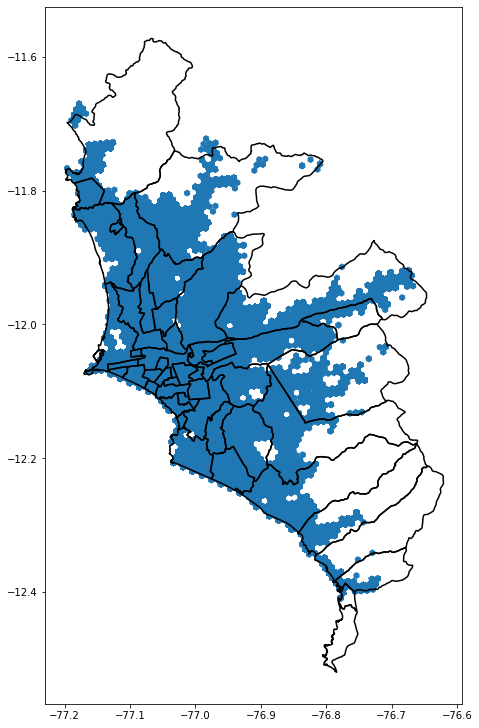

In [111]:
%%time
# fig, ax = plt.subplots(figsize = (10,10))
# lima_nodes.plot(ax=ax)

fig, ax = plt.subplots(constrained_layout=True, figsize=(10,10))

mapaLimaCallao.boundary.plot(ax=ax, color='black', )

lima_plot = lima_nodes

# lima_plot.plot(column='wazeinfo1400_minutes', ax=ax[0], legend=False)
lima_plot.plot( ax=ax)
amenities.plot()


In [114]:
%%time
amenities.plot(ax=ax, color='red')

CPU times: user 1.91 s, sys: 0 ns, total: 1.91 s
Wall time: 1.91 s


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

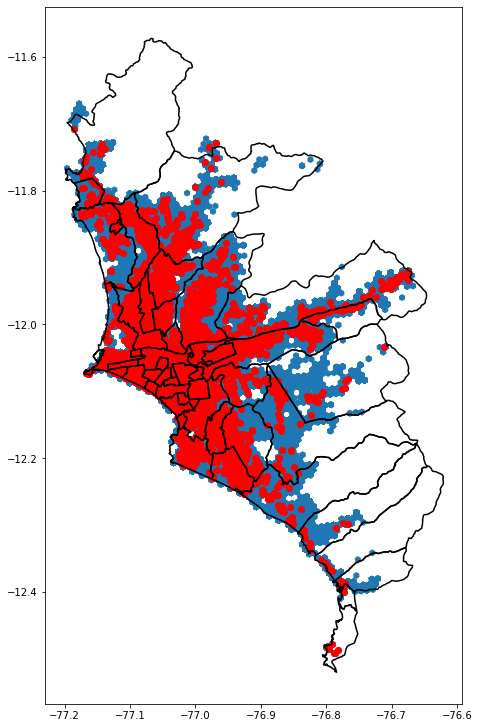

In [115]:
fig

In [120]:
%%time
street_graph = H
# Suponiendo que ya tienes cargado tu grafo de calles en 'street_graph' y tu geodataframe de amenities en 'amenities_df'
RESOLUTION = 8
# Asignar nodos a polígonos H3
node_to_h3 = assign_nodes_to_h3(street_graph, resolution=RESOLUTION)  # Ajusta la resolución según tu necesidad


CPU times: user 11.4 s, sys: 83.5 ms, total: 11.5 s
Wall time: 11.5 s


In [124]:
%%time
# Asignar amenities a polígonos H3
amenity_to_h3 = assign_amenities_to_h3(amenities, resolution=RESOLUTION)  # Ajusta la resolución según tu necesidad


CPU times: user 3.24 s, sys: 60 ms, total: 3.3 s
Wall time: 3.3 s


In [133]:
%%time
# Calcular rutas desde cada polígono H3 hacia cada amenity
routes = calculate_routes_from_h3_to_amenities(street_graph, node_to_h3, amenity_to_h3)


NodeNotFound: Either source 258066779 or target 3259019072 is not in G

In [130]:
# len(set(node_to_h3.values()))
# len(set(amenity_to_h3.values()))

In [ ]:
# Ejemplo de uso
# Suponiendo que ya tienes cargado tu grafo de calles en 'street_graph' y tu geodataframe de amenities en 'amenities_df'
RESOLUTION = 8
# Asignar nodos a polígonos H3
node_to_h3 = assign_nodes_to_h3(street_graph, resolution=RESOLUTION)  # Ajusta la resolución según tu necesidad

# Asignar amenities a polígonos H3
amenity_to_h3 = assign_amenities_to_h3(amenities_df, resolution=RESOLUTION)  # Ajusta la resolución según tu necesidad

# Calcular rutas desde cada polígono H3 hacia cada amenity
routes = calculate_routes_from_h3_to_amenities(street_graph, node_to_h3, amenity_to_h3)

# Ahora 'routes' contiene las rutas más cercanas desde cada polígono H3 hacia cada amenity
# Puedes acceder a las rutas como routes[h3_index_node][amenity_id]

In [131]:
street_graph

In [132]:
H

In [7]:
!ls data

GrafoLima_edges.csv			wazeresults30kmh_courthouse.csv
GrafoLima_edgeswaze.csv			wazeresults30kmh_hospital.csv
GrafoLima_edgeswaze.zip			wazeresults30kmh_police.csv
GrafoLima_nodes.csv			wazeresults30kmh_school.csv
GrafoLima_nodes.zip			wazeresults30kmh_university.csv
GrafoSanBorja_edges.csv			wazeresults_bank.csv
GrafoSanBorja_nodes.csv			wazeresults_courthouse.csv
LimaMinValues2Amenities.csv		wazeresults_hospital.csv
limaprivado_wazeresults_police.csv	wazeresults_police.csv
limaprivado_wazeresults_university.csv	wazeresults_school.csv
wazeresults30kmh_bank.csv		wazeresults_university.csv


# Calculando Ruta más cercana a un amenity

In [46]:
amenities_snap_limanodes['amenity'].unique()

array(['police', 'bank', 'school', 'courthouse', 'university', 'hospital'],
      dtype=object)

In [63]:
var_amenity = 'bank'

logger.info(f"Starting process for amenity {var_amenity} ")
cond = amenities_snap_limanodes['amenity'] == var_amenity

nearestnodes2amenities = list(amenities_snap_limanodes.loc[cond,:]['glima_osmid'].values)
nearestnodes2amenities = list(set(nearestnodes2amenities))
len(nearestnodes2amenities)

2024-02-15 21:32:12,710 :: INFO :: root :: 11378 :: Starting process for amenity bank 


839

In [64]:
# fig, ax = plt.subplots(figsize=(15,15))

# # nodes.plot(ax=ax, color='g')
# # edges.plot(ax=ax, color='yellow', alpha=0.5)
# lima_edges.plot(ax=ax)
# # cuscoshape.plot(ax=ax, color='gray', alpha=0.2)
# # rutascuscounique_gnodes.plot(ax=ax) 
# # inputdf.plot(ax=ax, color='red')

# # amenities_cols = ['unique_id', 'osmid', 'element_type', 'amenity', 'name',  'geometry',]
# # amenities.loc[cond, amenities_cols ].head(2)
# amenities_snap_limanodes.loc[cond, :].plot(ax=ax, color='green', marker='x' , )
# # amenities_gtransporte.loc[[874430122], :].plot(ax=ax, color='black', )

# lima_nodes.loc[nearestnodes2amenities,:].plot(ax=ax, color='red')

# # nodes.loc[nodes2plot,:].plot(ax=ax, color='red')
# # H_nodes.loc[[30965748],:].plot(ax=ax, color='black')
# # H_nodes.loc[[995446222],:].plot(ax=ax, color='cyan')
# # 30965748	995446222

In [65]:
nodes_source = list(set(lima_nodes.index))
print(len(nodes_source))
nodes_target = nearestnodes2amenities
print(len(nodes_target))

148111
839


In [66]:
nodes_sourcecrosstarget = list(itertools.product(nodes_source, nodes_target))
len(nodes_sourcecrosstarget)

124265129

In [70]:
def shortest_path_transporte(G, node_source, node_target):
    try:
        resdict = {}
        for w in ['wazeinfo0800_minutes', 'wazeinfo0800_km', 'wazeinfo1400_minutes', 'wazeinfo1400_km']:
#         for w in ['tiempoponderado30kmh']:
            res = nx.shortest_path_length(G, 
                                      source=node_source, 
                                      target=node_target, 
                                      weight=w)
            resdict[w] = res
    except Exception as e:
        resdict = {}
    return resdict  

In [68]:
nodes_sourcecrosstarget_df = pd.DataFrame(nodes_sourcecrosstarget, columns=['source', 'target'])
nodes_sourcecrosstarget_df.head(3)

,source,target
0,1738539013,108191745
1,1738539013,4410796033
2,1738539013,108191747


In [69]:
nodes_sourcecrosstarget_df.shape[0] , nodes_sourcecrosstarget_df.shape[0]/40

(124265129, 3106628.225)

In [ ]:
%%time
def process_row(row):
    result = shortest_path_transporte(H, row.source, row.target)
    return result

def split_dataframe(df, chunk_size):
    chunks = [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]
    return chunks

def apply_chunk(chunk):
    return chunk.apply(process_row, axis=1)

# Define the chunk size based on your dataset size and available resources
chunk_size = 500000

inputdf = nodes_sourcecrosstarget_df

data_chunks = split_dataframe(inputdf, chunk_size)

# Get the number of available CPU cores
# num_cores = cpu_count()
num_cores = int(inputdf.shape[0]/chunk_size)+1
if num_cores > cpu_count():
    num_cores = cpu_count()
# num_cores = cpu_count()
print(f"Num Cores --> {num_cores}")

# # Create a multiprocessing pool with the number of cores
with Pool(num_cores) as pool:
    logger.info("Multiprocessing started.")
    results = pool.map(apply_chunk, data_chunks)
    logger.info("Multiprocessing completed.")

Num Cores --> 40


2024-02-15 21:36:35,272 :: INFO :: root :: 11378 :: Multiprocessing started.


In [ ]:
results_df = pd.DataFrame(pd.concat(results), columns=['dict'])
results_df.head()

In [ ]:
cond = results_df['dict'].map(len)>0
results_df[cond]

In [ ]:
df = nodes_sourcecrosstarget_df.merge(results_df[cond], how='inner', left_index=True, right_index=True)
df.head()

In [ ]:
%%time
# Create an empty DataFrame with columns as unique keys from all dictionaries
columns = set().union(*(d.keys() for d in df['dict'] if d))
df2 = pd.DataFrame(columns=columns)
df2.head()

In [ ]:
%%time
# Iterate through each row's dictionary and populate the result DataFrame
for idx, row in df.iterrows():
    df2.loc[idx] = row['dict']

In [ ]:
# df.merge(df2, )
df3 = df[['source', 'target']].merge(df2, how='left', left_index=True, right_index=True)
df3

In [ ]:
df3.to_csv(f"data/limaprivado_wazeresults_{var_amenity}.csv", sep=';', index=False)

logger.info(f"Finishing process for amenity {var_amenity} ")

In [ ]:
!ls data/